In [1]:
from evalplus.data import (
    get_human_eval_plus,
    get_human_eval_plus_hash,
    get_mbpp_plus,
    get_mbpp_plus_hash,
    load_solutions,
)
import ast
from tqdm import tqdm
from datasets import load_dataset

/mnt/data-poseidon/haausing/miniconda3/envs/evalplus/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("evalplus/mbppplus")
mbpp_original = load_dataset("mbpp", "sanitized")
problems = get_mbpp_plus()
for elem in dataset["test"]:
    task_id = "Mbpp/{}".format(elem["task_id"])
    problems[task_id]["text"] = elem["prompt"]
dataset_dict = {"Mbpp/{}".format(e["task_id"]): e for e in dataset["test"]}
mbpp_original_dict = {"Mbpp/{}".format(e["task_id"]): e 
                      for partition in ["train", "test", "validation", "prompt"] 
                      for e in mbpp_original[partition]}

In [5]:
problems["Mbpp/2"]["prompt"]

'"""\nWrite a function to find the shared elements from the given two lists.\nassert set(similar_elements((3, 4, 5, 6),(5, 7, 4, 10))) == set((4, 5))\n"""\n'

In [7]:
dataset_dict["Mbpp/2"]

{'task_id': 2,
 'code': '\ndef similar_elements(test_tup1, test_tup2):\n  return tuple(set(test_tup1) & set(test_tup2))\n',
 'prompt': 'Write a function to find the shared elements from the given two lists.',
 'source_file': 'Benchmark Questions Verification V2.ipynb',
 'test_imports': [],
 'test_list': ['assert set(similar_elements((3, 4, 5, 6),(5, 7, 4, 10))) == set((4, 5))',
  'assert set(similar_elements((1, 2, 3, 4),(5, 4, 3, 7))) == set((3, 4))',
  'assert set(similar_elements((11, 12, 14, 13),(17, 15, 14, 13))) == set((13, 14))'],
 'test': "\n\nimport numpy as np\n\ndef is_floats(x) -> bool:\n    # check if it is float; List[float]; Tuple[float]\n    if isinstance(x, float):\n        return True\n    if isinstance(x, (list, tuple)):\n        return all(isinstance(i, float) for i in x)\n    if isinstance(x, np.ndarray):\n        return x.dtype == np.float64 or x.dtype == np.float32\n    return False\n\n\ndef assertion(out, exp, atol):\n    exact_match = out == exp\n\n    if atol 

In [3]:
# load json file
import json
import pandas as pd
def load_json(dir_path: str):
    with open(dir_path, "r") as f:
        return json.load(f)

outputs_dir = "/mnt/scratch-artemis/haausing/code_reranking/evalplus_outputs/mbpp"
llm = "deepseek-coder-7b-instruct-v1.5_temp_0.8"

In [4]:
eval_results = load_json(f"{outputs_dir}/{llm}/eval_results_base_plus.json")
for task_id in eval_results["eval"]:
    eval_results["eval"][task_id] = sorted(eval_results["eval"][task_id], key=lambda x: int(x["solution_id"]))

In [5]:
log_probs = pd.read_pickle(f"{outputs_dir}/{llm}/logprobs.pkl")

In [6]:
execution_results = pd.read_pickle(f"{outputs_dir}/{llm}/new_exec_outs.pkl")
exec_outs = {}
for e in execution_results:
    if ("Mbpp/"+e["task_id"]) not in exec_outs:
        exec_outs["Mbpp/"+e["task_id"]] = {}
    if e["solution_id"] not in exec_outs["Mbpp/"+e["task_id"]]:
        exec_outs["Mbpp/"+e["task_id"]][e["solution_id"]] = {}
    exec_outs["Mbpp/"+e["task_id"]][e["solution_id"]][e["base_plus"]] = e["execution"]
execution_results = None

In [7]:
ref_execution_results = pd.read_pickle(f"/home/haausing/.cache/evalplus/ebe95df0d5220f00cedd6f4bddea35e4.pkl")

In [8]:
for task_id in ref_execution_results:
    assert len(ref_execution_results[task_id]["base"]) > 0
    try:
        assert len(ref_execution_results[task_id]["plus"]) + len(ref_execution_results[task_id]["base"])> 0
    except:
        print(task_id)

In [9]:
#['code', 'exec_match', 'linear_score', 'exec_result', 'gen_prob', 'norm_gen_prob']
def create_data():
    train_data = []
    dev_data = []
    test_data = []
    for elem in tqdm(dataset["test"]):
        task_id = "Mbpp/{}".format(elem["task_id"])
        base_input_counts = len(ref_execution_results[task_id]["base"])
        plus_input_counts = len(ref_execution_results[task_id]["plus"])
        test_list = [e for e in problems[task_id]["assertion"].strip().split("\n") if e.startswith("assert ")]
        for i in range(len(test_list)):
            if test_list[i].startswith("assert math.isclose("):
                test_list[i] = test_list[i].replace("math.isclose(", "")
                test_list[i] = test_list[i].replace(", rel_tol=0.001)", "")
                test_list[i] = ",".join(test_list[i].split(",")[:-1]) + " ==" + test_list[i].split(",")[-1]
        metadata = {"text": problems[task_id]["text"],
                    "test_list": test_list,
                    "task_id": task_id,}
        for test in metadata["test_list"]:
            ast.parse(test)
        gold_program = {
            "code": problems[task_id]["canonical_solution"], 
            "base": {
                "exec_match": 1, 
                "linear_score": 1.0, 
                "exec_result": 
                    [
                    {
                        "result": "passed", 
                        "tracing_local_list": 
                            [
                                {
                                    "_return_val": 
                                        {
                                            "type": str(type(ref_execution_results[task_id]["base"][i])),
                                            "str_value": str(ref_execution_results[task_id]["base"][i]),
                                        }
                                }
                            ]
                    }
                    for i in range(base_input_counts)
                    ],
            },
            "plus": {
                "exec_match": 1,
                "linear_score": 1.0,
                "plus_exec_result": 
                    [
                    {
                        "result": "passed", 
                        "tracing_local_list": 
                            [
                                {
                                    "_return_val": 
                                        {
                                            "type": str(type(ref_execution_results[task_id]["plus"][i])),
                                            "str_value": str(ref_execution_results[task_id]["plus"][i]),
                                        }
                                }
                            ]
                    }
                    for i in range(plus_input_counts)
                    ],
            },
            "gen_prob": 0, 
            "norm_gen_prob": 0}
        generated_programs = []
        for e in eval_results["eval"][task_id]:
            sample_dict = {"code": e["solution"],
                        "base": {
                            "exec_match": int(e["base_status"] == "pass"),
                            "linear_score": sum(e["base_details"]) / base_input_counts,
                            },
                        "plus":{
                            "exec_match": int(e["base_status"] == e["plus_status"] == "pass"),
                            "linear_score": (sum(e["base_details"]) + sum(e["plus_details"])) / (base_input_counts + plus_input_counts),
                        },
                        "gen_prob": sum(log_probs[task_id.replace("/","_")][int(e["solution_id"])]),
                        "norm_gen_prob": sum(log_probs[task_id.replace("/","_")][int(e["solution_id"])])/len(log_probs[task_id.replace("/","_")][int(e["solution_id"])]),
                        }
            # try to parse e["solution"] with ast
            try:
                ast.parse(e["solution"])
            except:
                assert sample_dict["base"]["exec_match"] == sample_dict["plus"]["exec_match"] == 0
                sample_dict["base"]["exec_result"] = "ERROR: program is not parsable"
                sample_dict["plus"]["exec_result"] = "ERROR: program is not parsable"
                generated_programs.append(sample_dict)
                continue
            base_eval_results = []
            plus_eval_results = []
            for i in range(base_input_counts):
                if "failed" in exec_outs[task_id][int(e["solution_id"])]:
                    base_eval_results.append({"result": "failed: dictionary unloadable"})
                    continue
                # if we don't find the output or if it's not included in the details, 
                # we see that the code is actually not producing outputs, referring to assertion error in LEVER
                if i not in exec_outs[task_id][int(e["solution_id"])]["base"] or len(e["base_details"]) <= i:
                    base_eval_results.append({"result": "failed: assertion error"})
                    continue
                if type(exec_outs[task_id][int(e["solution_id"])]["base"][i]) == str and exec_outs[task_id][int(e["solution_id"])]["base"][i] == "failed: ":
                    base_eval_results.append({"result": "failed: unknown error"})
                    continue
                if type(exec_outs[task_id][int(e["solution_id"])]["base"][i]) == str and exec_outs[task_id][int(e["solution_id"])]["base"][i] == "failed: Time out!":
                    base_eval_results.append({"result": "timeout"})
                    continue
                if type(exec_outs[task_id][int(e["solution_id"])]["base"][i]) == str and exec_outs[task_id][int(e["solution_id"])]["base"][i].startswith("failed: "):
                    base_eval_results.append({"result": exec_outs[task_id][int(e["solution_id"])]["base"][i]})
                    continue
                base_eval_results.append(
                    {
                        "result": "passed", 
                        "tracing_local_list": 
                            [
                                {
                                    "_return_val":
                                        {
                                            "type": str(type(exec_outs[task_id][int(e["solution_id"])]["base"][i])), 
                                            "str_value": str(exec_outs[task_id][int(e["solution_id"])]["base"][i]),
                                        }
                                }
                            ]
                    }
                )

            for i in range(plus_input_counts):
                if "failed" in exec_outs[task_id][int(e["solution_id"])]:
                    plus_eval_results.append({"result": "failed: dictionary unloadable"})
                    continue
                # if we don't find the output or if it's not included in the details, 
                # we see that the code is actually not producing outputs, referring to assertion error in LEVER
                if i not in exec_outs[task_id][int(e["solution_id"])]["plus"] or len(e["plus_details"]) <= i:
                    plus_eval_results.append({"result": "failed: assertion error"})
                    continue
                if type(exec_outs[task_id][int(e["solution_id"])]["plus"][i]) == str and exec_outs[task_id][int(e["solution_id"])]["plus"][i] == "failed: ":
                    plus_eval_results.append({"result": "failed: unknown error"})
                    continue
                if type(exec_outs[task_id][int(e["solution_id"])]["plus"][i]) == str and exec_outs[task_id][int(e["solution_id"])]["plus"][i] == "failed: Time out!":
                    plus_eval_results.append({"result": "timeout"})
                    continue
                if type(exec_outs[task_id][int(e["solution_id"])]["plus"][i]) == str and exec_outs[task_id][int(e["solution_id"])]["plus"][i].startswith("failed: "):
                    plus_eval_results.append({"result": exec_outs[task_id][int(e["solution_id"])]["plus"][i]})
                    continue
                plus_eval_results.append(
                    {
                        "result": "passed", 
                        "tracing_local_list": 
                            [
                                {
                                    "_return_val":
                                        {
                                            "type": str(type(exec_outs[task_id][int(e["solution_id"])]["plus"][i])), 
                                            "str_value": str(exec_outs[task_id][int(e["solution_id"])]["plus"][i]),
                                        }
                                }
                            ]
                    }
                )
            sample_dict["base"]["exec_result"] = base_eval_results
            sample_dict["plus"]["exec_result"] = plus_eval_results
            generated_programs.append(sample_dict)
        

        if int(elem["task_id"]) > 600: # this is for the training partition
            train_data.append({"metadata": metadata,
                            "gold_program": gold_program,
                            "generated_programs": generated_programs,})
        elif int(elem["task_id"]) > 510 and int(elem["task_id"]) <=600: # this is for the development partition
            dev_data.append({"metadata": metadata,
                            "gold_program": gold_program,
                            "generated_programs": generated_programs,})
        elif int(elem["task_id"]) > 10 and int(elem["task_id"]) <= 510: # this is for the test partition
            test_data.append({"metadata": metadata,
                            "gold_program": gold_program,
                            "generated_programs": generated_programs,})
    return train_data, dev_data, test_data

In [10]:
# save a list of dictionaries to jsonl file
prefix = "/mnt/scratch-artemis/haausing/code_reranking/code/lever/data/mbpp/"
import json
train_data, dev_data, test_data = create_data()
with open(prefix + f"{llm}_train.jsonl", "w") as f:
    for elem in train_data:
        f.write(json.dumps(elem) + "\n")
with open(prefix + f"{llm}_dev.jsonl", "w") as f:
    for elem in dev_data:
        f.write(json.dumps(elem) + "\n")
with open(prefix + f"{llm}_test.jsonl", "w") as f:
    for elem in test_data:
        f.write(json.dumps(elem) + "\n")

100%|██████████| 399/399 [01:39<00:00,  4.00it/s]


In [12]:
#read the json files to list of dictionaries
prefix = "/mnt/scratch-artemis/haausing/code_reranking/code/lever/data/mbpp/"
#llm = "code-llama-13b_temp_0.8"
llm = "deepseek-coder-7b-instruct-v1.5_temp_0.8"
import json
def read_jsonl(file_path: str):
    with open(file_path, "r") as f:
        return [json.loads(e) for e in f.readlines()]

train_data = read_jsonl(prefix + f"{llm}_train.jsonl")
dev_data = read_jsonl(prefix + f"{llm}_dev.jsonl")
test_data = read_jsonl(prefix + f"{llm}_test.jsonl")

In [13]:
test_data[57]["metadata"]

{'text': 'Write a function to check if a string represents an integer or not.',
 'test_list': ['assert check_integer("python")==False',
  'assert check_integer("1")==True',
  'assert check_integer("12345")==True'],
 'task_id': 'Mbpp/113'}

In [14]:
base_linear_score = []
plus_linear_score = []
for sample in train_data:
    for i, generated_program in enumerate(sample["generated_programs"]):
        base_linear_score.append(generated_program["base"]["linear_score"])
        plus_linear_score.append(generated_program["plus"]["linear_score"])

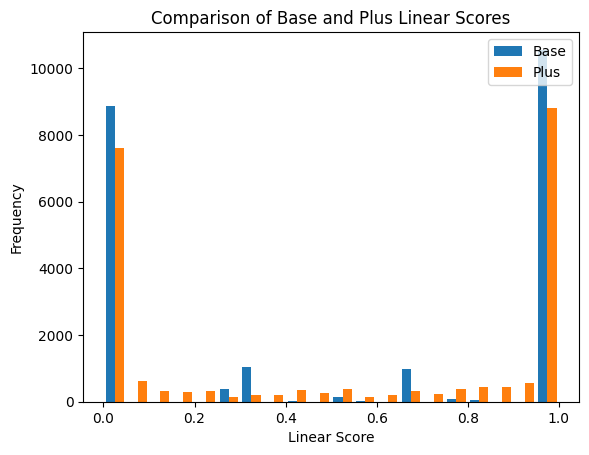

In [15]:
import matplotlib.pyplot as plt

plt.hist([base_linear_score, plus_linear_score], bins=20, label=['Base', 'Plus'])
plt.legend(loc='upper right')
plt.title('Comparison of Base and Plus Linear Scores')
plt.xlabel('Linear Score')
plt.ylabel('Frequency')
plt.show()

# change the plot above to plot relative frequency
